# Assignment 2

This assignment serves as a comprehensive evaluation of your machine learning skills, encompassing not only the technical aspects of model development but also your ability to analyze, interpret, and present data insights effectively. As such, it's essential to ensure that your submission is complete, functional, and devoid of any obvious gaps, as if you were delivering this project to a client.

To achieve this, leverage the full capabilities of Markdown and the interactive visualization tools available in Jupyter notebooks to craft a well-structured and visually appealing report of your findings. Your report should clearly communicate the insights you've gained from the exploratory data analysis, the rationale behind your data preprocessing and feature engineering decisions, and a thorough analysis of feature importance. High-quality visualizations and well-organized documentation will not only support your analysis but also make your results more accessible and understandable to your audience.

Remember, the ability to present complex results in an intuitive and engaging manner is a crucial skill, almost as important as the technical proficiency in model building and data analysis. Treat this assignment as an opportunity to showcase your skills in both areas.

## Instructions
- Your submission should be a `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. It should include the answers to the questions in markdown cells, your data analysis and results.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell. [Academic misconduct policy](https://wiki.innopolis.university/display/DOE/Academic+misconduct+policy)
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions and decisions.

## Self-Reliance and Exploration
In this task, you're encouraged to rely on your resourcefulness and creativity. Dive into available resources, experiment with various solutions, and learn from every outcome. While our team is here to clarify task details and offer conceptual guidance, we encourage you to first seek answers independently. This approach is vital for developing your problem-solving skills in machine learning.



# Task 2: Image Classification with CNNs (50%)

In this task, you'll dive into the world of Convolutional Neural Networks (CNNs) by working with the CIFAR-10 dataset, a staple in image classification challenges. Your goal is to build and evaluate two different CNN models to classify images into one of the ten categories accurately.

The dataset is availabel in pytorch and keras.

## Part 1: Custom CNN Model (20%)

- Design and train a CNN model from scratch tailored for the CIFAR-10 dataset.
- Focus on the architecture that you believe will perform best for this specific task.
- Integrate various techniques such as batch normalization, dropout, learning rate schedulers, and early stopping to improve model training. Experiment with these methods and finetune them to see how they affect training stability, convergence speed, and overall performance.

## Part 2: Transfer Learning Model (20%)

- Implement a transfer learning approach using a pre-trained model of your choice.
- Fine-tune the model on the CIFAR-10 dataset to achieve the best possible performance.

## Evaluation (10%)

Ensure that both models are robust and generalized well to unseen data.

After training both models, you will evaluate them on a provided test dataset.

Compare your models based on:
- **AUC-ROC**: How well does each model discriminate between classes?
- **Model Size**: Consider the trade-offs in model complexity.
- **Inference Speed**: Evaluate how quickly your model can predict classes for new images.

Reflect on the performance, size, and inference speed of both models. What insights can you draw from these comparisons?

### Learning Objectives

- Understand and apply CNNs for image classification.
- Explore the impact of model architecture on performance and efficiency.
- Learn the process and benefits of transfer learning in deep learning.

Remember, the key to this task is not just about achieving the highest accuracy but also understanding the strengths and limitations of different approaches in machine learning model development.

**Part 1: Custom CNN Model**

In [8]:
import torch
from torch.utils import data
from torchvision import datasets, transforms

train_batch_size = 128
test_batch_size = 128

# put augmentations
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='cifar10',
                                 train=True,
                                 transform=train_transforms,
                                 download=True)

train_data_loader = data.DataLoader(train_dataset,
                                    batch_size=train_batch_size,
                                    shuffle=True,
                                    drop_last=True,
                                    num_workers=2)

test_dataset = datasets.CIFAR10(root='cifar10',
                                 train=False,
                                 transform=test_transforms,
                                 download=True)

test_data_loader = data.DataLoader(test_dataset,
                                    batch_size=test_batch_size,
                                    shuffle=False,
                                    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


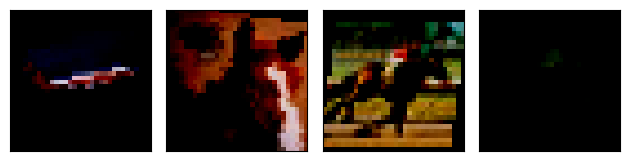

In [9]:
# check the results of transformations
import matplotlib.pyplot as plt
images, _ = next(iter(train_data_loader))

fig, axs = plt.subplots(nrows=1, ncols=4)

for i in range(4):
    ax = axs[i]
    ax.imshow(images[i].numpy().transpose(1,2,0))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define custom model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Build your model
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                padding=1,
                kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            # padding=1
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.25)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      padding=1), #32, 64, 3
            nn.ReLU(),
            nn.BatchNorm2d(128), #64
        )
        self.linear1 = nn.Sequential(
            nn.Linear(128*16*16, 512), #64*11*11, 256
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 10) #256, 10
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CustomModel().to(device)

print(f'Device: {device}')

print(model)

Device: cuda
CustomModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.25, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=32768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [11]:
import operator
import numpy as np

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        '''
        :param tolerance: number of epochs that the metric doesn't improve
        :param min_delta: minimum improvement (was 0)
        :param mode: 'min' or 'max' to minimize or maximize the metric
        '''
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt


    def __call__(self, metric)->bool:
        ''' This function should return True if `metric` is not improving for
            'tolerance' calls
        '''
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

In [12]:
from time import time
from tqdm import tqdm

# define train function
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    epoch_loss = 0
    start_time = time()
    correct = 0
    iteration = 0

    bar = tqdm(train_loader)
    for data, target in bar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        iteration += 1
        bar.set_postfix({"Loss": format(epoch_loss/iteration, '.6f')})

    acc = 100. * correct / len(train_loader.dataset)
    print(f'\rTrain Epoch: {epoch}, elapsed time:{time()-start_time:.2f}s')
    return epoch_loss, acc

# define function to perform of test data
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    acc = 100. * correct / len(test_loader.dataset)
    return test_loss, acc

In [13]:
from torch.optim import SGD, lr_scheduler
from copy import deepcopy

# set up training parameters
epochs = 60

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                           factor=0.3, patience=3,
                                           verbose=True, min_lr=0.001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(model.state_dict())

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy


def training(writing=False):
    if writing:
        writer = SummaryWriter(log_dir='runs/model')
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_data_loader, criterion, optimizer, epoch)
        # Update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(model, device, test_data_loader, criterion)
        # Terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # Deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        if writing:
            writer.add_scalars('Loss',
                            {
                                'train': train_loss,
                                'test': test_loss
                            },
                            epoch)

            writer.add_scalars('Accuracy',
                            {
                                'train': train_acc,
                                'test': test_acc
                            },
                            epoch)
        else:
            print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
            print(f"Training loss {train_loss}, test loss {test_loss}")

    torch.save(model.state_dict(), "model.pt")
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_model.pt")
    if writing:
        writer.close()

training()

100%|██████████| 390/390 [00:31<00:00, 12.46it/s, Loss=2.331746]

Train Epoch: 1, elapsed time:31.31s


Training accuracy 11.774, test accuracy 10.07
Training loss 909.3809177875519, test loss 181.92741465568542


100%|██████████| 390/390 [00:31<00:00, 12.28it/s, Loss=2.304075]

Train Epoch: 2, elapsed time:31.76s


Training accuracy 10.024, test accuracy 12.51
Training loss 898.5892980098724, test loss 180.5175006389618


100%|██████████| 390/390 [00:32<00:00, 11.99it/s, Loss=2.298613]

Train Epoch: 3, elapsed time:32.52s


Training accuracy 10.552, test accuracy 9.97
Training loss 896.4591448307037, test loss 181.9602072238922


100%|██████████| 390/390 [00:33<00:00, 11.57it/s, Loss=2.300292]

Train Epoch: 4, elapsed time:33.73s


Training accuracy 10.608, test accuracy 10.0
Training loss 897.1140344142914, test loss 182.0371437072754


100%|██████████| 390/390 [00:31<00:00, 12.34it/s, Loss=2.304060]

Train Epoch: 5, elapsed time:31.61s


Training accuracy 10.066, test accuracy 10.0
Training loss 898.5834069252014, test loss 182.13287949562073


100%|██████████| 390/390 [00:32<00:00, 12.14it/s, Loss=2.303930]

Train Epoch: 6, elapsed time:32.12s


Training accuracy 10.124, test accuracy 10.0
Training loss 898.5328094959259, test loss 181.96744751930237


100%|██████████| 390/390 [00:31<00:00, 12.21it/s, Loss=2.304421]

Train Epoch: 7, elapsed time:31.95s


Training accuracy 9.852, test accuracy 10.0
Training loss 898.7242639064789, test loss 181.9500880241394


100%|██████████| 390/390 [00:30<00:00, 12.60it/s, Loss=2.303119]

Train Epoch: 8, elapsed time:30.97s


Training accuracy 10.04, test accuracy 11.06
Training loss 898.2165191173553, test loss 181.64427971839905


100%|██████████| 390/390 [00:31<00:00, 12.23it/s, Loss=2.141577]

Train Epoch: 9, elapsed time:31.89s


Training accuracy 17.04, test accuracy 24.75
Training loss 835.2148758172989, test loss 151.16114366054535


100%|██████████| 390/390 [00:31<00:00, 12.46it/s, Loss=2.004121]

Train Epoch: 10, elapsed time:31.32s


Training accuracy 21.482, test accuracy 26.25
Training loss 781.6072871685028, test loss 146.26520705223083


100%|██████████| 390/390 [00:31<00:00, 12.45it/s, Loss=1.769443]

Train Epoch: 11, elapsed time:31.33s


Training accuracy 32.654, test accuracy 50.89
Training loss 690.0828669071198, test loss 107.47026741504669


100%|██████████| 390/390 [00:32<00:00, 11.95it/s, Loss=1.450915]

Train Epoch: 12, elapsed time:32.65s


Training accuracy 47.17, test accuracy 58.18
Training loss 565.8569699525833, test loss 93.03705179691315


100%|██████████| 390/390 [00:31<00:00, 12.49it/s, Loss=1.300897]

Train Epoch: 13, elapsed time:31.22s


Training accuracy 53.31, test accuracy 62.49
Training loss 507.3496723175049, test loss 83.62745171785355


100%|██████████| 390/390 [00:31<00:00, 12.45it/s, Loss=1.189894]

Train Epoch: 14, elapsed time:31.33s


Training accuracy 57.556, test accuracy 65.06
Training loss 464.058502137661, test loss 79.32698518037796


100%|██████████| 390/390 [00:31<00:00, 12.22it/s, Loss=1.087687]

Train Epoch: 15, elapsed time:31.93s


Training accuracy 61.53, test accuracy 65.38
Training loss 424.1979257464409, test loss 79.5657229423523


100%|██████████| 390/390 [00:30<00:00, 12.64it/s, Loss=1.046139]

Train Epoch: 16, elapsed time:30.87s


Training accuracy 63.22, test accuracy 68.81
Training loss 407.9941594004631, test loss 70.40931707620621


100%|██████████| 390/390 [00:31<00:00, 12.56it/s, Loss=0.987258]

Train Epoch: 17, elapsed time:31.05s


Training accuracy 65.172, test accuracy 71.77
Training loss 385.03064918518066, test loss 64.45344841480255


100%|██████████| 390/390 [00:32<00:00, 11.99it/s, Loss=0.950231]

Train Epoch: 18, elapsed time:32.54s


Training accuracy 66.642, test accuracy 71.9
Training loss 370.58991891145706, test loss 65.14687740802765


100%|██████████| 390/390 [00:33<00:00, 11.78it/s, Loss=0.902379]

Train Epoch: 19, elapsed time:33.10s


Training accuracy 68.392, test accuracy 72.97
Training loss 351.9279669523239, test loss 62.618470311164856


100%|██████████| 390/390 [00:31<00:00, 12.55it/s, Loss=0.884260]

Train Epoch: 20, elapsed time:31.08s


Training accuracy 68.944, test accuracy 74.72
Training loss 344.8615530729294, test loss 58.39217483997345


100%|██████████| 390/390 [00:32<00:00, 12.02it/s, Loss=0.853191]

Train Epoch: 21, elapsed time:32.46s


Training accuracy 70.102, test accuracy 74.98
Training loss 332.74451154470444, test loss 57.03694689273834


100%|██████████| 390/390 [00:31<00:00, 12.23it/s, Loss=0.820043]

Train Epoch: 22, elapsed time:31.88s


Training accuracy 71.184, test accuracy 76.06
Training loss 319.81685745716095, test loss 54.84442302584648


100%|██████████| 390/390 [00:31<00:00, 12.41it/s, Loss=0.799224]

Train Epoch: 23, elapsed time:31.44s


Training accuracy 72.212, test accuracy 75.33
Training loss 311.6975269317627, test loss 56.097238183021545


100%|██████████| 390/390 [00:32<00:00, 12.08it/s, Loss=0.776036]

Train Epoch: 24, elapsed time:32.28s


Training accuracy 72.712, test accuracy 77.27
Training loss 302.65395295619965, test loss 52.97905597090721


100%|██████████| 390/390 [00:32<00:00, 11.95it/s, Loss=0.755471]

Train Epoch: 25, elapsed time:32.63s


Training accuracy 73.58, test accuracy 77.08
Training loss 294.63371884822845, test loss 53.456170201301575


100%|██████████| 390/390 [00:32<00:00, 11.83it/s, Loss=0.740549]

Train Epoch: 26, elapsed time:32.98s


Training accuracy 74.202, test accuracy 78.64
Training loss 288.8139658868313, test loss 50.84295418858528


100%|██████████| 390/390 [00:31<00:00, 12.28it/s, Loss=0.723657]


Train Epoch: 27, elapsed time:31.76s
Training accuracy 74.518, test accuracy 78.91
Training loss 282.2260776460171, test loss 49.29795745015144


100%|██████████| 390/390 [00:32<00:00, 11.91it/s, Loss=0.706174]

Train Epoch: 28, elapsed time:32.74s


Training accuracy 75.418, test accuracy 77.75
Training loss 275.4079403281212, test loss 52.18290966749191


100%|██████████| 390/390 [00:31<00:00, 12.29it/s, Loss=0.689804]

Train Epoch: 29, elapsed time:31.74s


Training accuracy 75.942, test accuracy 78.98
Training loss 269.0234974324703, test loss 49.49381071329117


100%|██████████| 390/390 [00:31<00:00, 12.39it/s, Loss=0.687246]

Train Epoch: 30, elapsed time:31.47s


Training accuracy 76.142, test accuracy 80.2
Training loss 268.02609115839005, test loss 47.09832763671875


100%|██████████| 390/390 [00:32<00:00, 11.94it/s, Loss=0.668003]

Train Epoch: 31, elapsed time:32.68s


Training accuracy 76.624, test accuracy 79.74
Training loss 260.52128571271896, test loss 48.65419274568558


100%|██████████| 390/390 [00:32<00:00, 11.95it/s, Loss=0.659199]

Train Epoch: 32, elapsed time:32.65s


Training accuracy 76.986, test accuracy 79.75
Training loss 257.08749291300774, test loss 48.5019097328186


100%|██████████| 390/390 [00:32<00:00, 12.01it/s, Loss=0.643974]

Train Epoch: 33, elapsed time:32.48s


Training accuracy 77.53, test accuracy 79.48
Training loss 251.14982056617737, test loss 51.33600923418999


100%|██████████| 390/390 [00:31<00:00, 12.23it/s, Loss=0.632872]

Train Epoch: 34, elapsed time:31.89s


Training accuracy 77.994, test accuracy 80.51
Training loss 246.82025170326233, test loss 48.09934687614441


100%|██████████| 390/390 [00:32<00:00, 11.82it/s, Loss=0.620405]

Train Epoch: 35, elapsed time:32.99s


Training accuracy 78.382, test accuracy 79.66
Training loss 241.95798003673553, test loss 48.40579980611801


100%|██████████| 390/390 [00:32<00:00, 12.16it/s, Loss=0.612489]

Train Epoch: 36, elapsed time:32.09s


Training accuracy 78.662, test accuracy 80.84
Training loss 238.8707773387432, test loss 46.46601873636246


100%|██████████| 390/390 [00:31<00:00, 12.30it/s, Loss=0.604074]

Train Epoch: 37, elapsed time:31.70s


Training accuracy 78.928, test accuracy 80.74
Training loss 235.58886149525642, test loss 49.04192355275154


100%|██████████| 390/390 [00:32<00:00, 11.92it/s, Loss=0.589682]

Train Epoch: 38, elapsed time:32.72s


Training accuracy 79.432, test accuracy 80.32
Training loss 229.9758698940277, test loss 48.56535032391548


100%|██████████| 390/390 [00:32<00:00, 12.01it/s, Loss=0.586109]

Train Epoch: 39, elapsed time:32.49s


Training accuracy 79.366, test accuracy 81.04
Training loss 228.58249267935753, test loss 48.43477547168732


100%|██████████| 390/390 [00:31<00:00, 12.44it/s, Loss=0.574709]

Train Epoch: 40, elapsed time:31.35s


Training accuracy 79.946, test accuracy 80.49
Training loss 224.13637268543243, test loss 47.36672621965408


100%|██████████| 390/390 [00:32<00:00, 12.13it/s, Loss=0.569197]

Train Epoch: 41, elapsed time:32.17s


Training accuracy 80.178, test accuracy 80.85
Training loss 221.98691099882126, test loss 47.158922374248505


100%|██████████| 390/390 [00:32<00:00, 11.95it/s, Loss=0.562216]

Train Epoch: 42, elapsed time:32.63s


Training accuracy 80.14, test accuracy 81.94
Training loss 219.26441848278046, test loss 44.95096045732498


100%|██████████| 390/390 [00:31<00:00, 12.38it/s, Loss=0.554191]

Train Epoch: 43, elapsed time:31.50s


Training accuracy 80.558, test accuracy 81.63
Training loss 216.13437509536743, test loss 44.64883244037628


100%|██████████| 390/390 [00:31<00:00, 12.36it/s, Loss=0.541507]

Train Epoch: 44, elapsed time:31.56s


Training accuracy 81.144, test accuracy 80.42
Training loss 211.1878020465374, test loss 46.46067741513252


100%|██████████| 390/390 [00:32<00:00, 11.98it/s, Loss=0.535325]

Train Epoch: 45, elapsed time:32.55s


Training accuracy 81.208, test accuracy 81.42
Training loss 208.77687779068947, test loss 46.61137807369232


100%|██████████| 390/390 [00:31<00:00, 12.38it/s, Loss=0.527314]

Train Epoch: 46, elapsed time:31.51s


Training accuracy 81.558, test accuracy 81.39
Training loss 205.65248647332191, test loss 45.38159003853798


100%|██████████| 390/390 [00:31<00:00, 12.42it/s, Loss=0.525340]

Train Epoch: 47, elapsed time:31.42s


Training accuracy 81.812, test accuracy 82.26
Training loss 204.88275960087776, test loss 43.91082662343979


100%|██████████| 390/390 [00:33<00:00, 11.72it/s, Loss=0.516548]

Train Epoch: 48, elapsed time:33.28s


Training accuracy 81.754, test accuracy 81.88
Training loss 201.45380568504333, test loss 48.5185726583004


100%|██████████| 390/390 [00:32<00:00, 11.98it/s, Loss=0.505376]

Train Epoch: 49, elapsed time:32.55s


Training accuracy 82.37, test accuracy 81.64
Training loss 197.09672209620476, test loss 47.81691271066666


100%|██████████| 390/390 [00:31<00:00, 12.44it/s, Loss=0.509752]

Train Epoch: 50, elapsed time:31.37s


Training accuracy 82.168, test accuracy 82.32
Training loss 198.8032906651497, test loss 44.37927803397179


100%|██████████| 390/390 [00:31<00:00, 12.22it/s, Loss=0.500847]

Train Epoch: 51, elapsed time:31.94s


Training accuracy 82.492, test accuracy 81.23
Training loss 195.33019000291824, test loss 48.18954914808273


100%|██████████| 390/390 [00:32<00:00, 12.02it/s, Loss=0.489782]

Train Epoch: 52, elapsed time:32.44s


Training accuracy 82.856, test accuracy 82.02
Training loss 191.0151046514511, test loss 46.040171414613724


100%|██████████| 390/390 [00:31<00:00, 12.42it/s, Loss=0.483365]

Train Epoch: 53, elapsed time:31.42s


Training accuracy 83.198, test accuracy 82.27
Training loss 188.51218581199646, test loss 47.80415663123131


100%|██████████| 390/390 [00:31<00:00, 12.44it/s, Loss=0.476173]

Train Epoch: 54, elapsed time:31.36s



Early stopping



In [ ]:
# evaluate the trained custom model on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of a Custom Model on test set: {100 * correct / total}%")

Accuracy of a Custom Model on test set: 81.64%


**Part 2: Transfer Learning Model**

In [ ]:
import torchvision.models as models

# load pre-trained ResNet model
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet = resnet.to(device)

print(f'\nDevice: {device}')

print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]



Device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [ ]:
# set up training parameters
epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = SGD(resnet.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3,
                                                           patience=3, verbose=True, min_lr=0.001)
early_stopping = EarlyStopping(tolerance=7, mode='min')

best_model_wts = deepcopy(resnet.state_dict())

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import copy


def training(writing=False):
    if writing:
        writer = SummaryWriter(log_dir='runs/resnet')
    best_acc = 0.0
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(resnet, device, train_data_loader, criterion, optimizer, epoch)
        # update learning rate if needed
        scheduler.step(train_loss)

        test_loss, test_acc = test(resnet, device, test_data_loader, criterion)
        # terminate training if loss stopped to decrease
        if early_stopping(test_loss):
            print('\nEarly stopping\n')
            break
        # deep copy the weight of model if its accuracy is the best for now
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(resnet.state_dict())
        if writing:
            writer.add_scalars('Loss',
                            {
                                'train': train_loss,
                                'test': test_loss
                            },
                            epoch)

            writer.add_scalars('Accuracy',
                            {
                                'train': train_acc,
                                'test': test_acc
                            },
                            epoch)
        else:
            print(f"Training accuracy {train_acc}, test accuracy {test_acc}")
            print(f"Training loss {train_loss}, test loss {test_loss}")

    torch.save(resnet.state_dict(), "resnet.pt")
    resnet.load_state_dict(best_model_wts)
    torch.save(resnet.state_dict(), "best_resnet_model.pt")
    if writing:
        writer.close()

training()

100%|██████████| 390/390 [00:42<00:00,  9.27it/s, Loss=2.647851]

Train Epoch: 1, elapsed time:42.08s


Training accuracy 19.88, test accuracy 32.31
Training loss 1032.6617460250854, test loss 145.15613400936127


100%|██████████| 390/390 [00:33<00:00, 11.81it/s, Loss=1.744359]

Train Epoch: 2, elapsed time:33.03s


Training accuracy 33.488, test accuracy 38.89
Training loss 680.3001248836517, test loss 139.28624784946442


100%|██████████| 390/390 [00:32<00:00, 11.82it/s, Loss=1.545576]

Train Epoch: 3, elapsed time:33.00s


Training accuracy 42.682, test accuracy 46.58
Training loss 602.7748250961304, test loss 119.0423914194107


100%|██████████| 390/390 [00:34<00:00, 11.27it/s, Loss=1.436448]

Train Epoch: 4, elapsed time:34.61s


Training accuracy 47.514, test accuracy 50.52
Training loss 560.2145280838013, test loss 108.22247403860092


100%|██████████| 390/390 [00:34<00:00, 11.35it/s, Loss=1.320275]

Train Epoch: 5, elapsed time:34.36s


Training accuracy 51.948, test accuracy 58.28
Training loss 514.9072225093842, test loss 92.14888048171997


100%|██████████| 390/390 [00:34<00:00, 11.25it/s, Loss=1.229172]

Train Epoch: 6, elapsed time:34.67s


Training accuracy 55.748, test accuracy 62.16
Training loss 479.3769330382347, test loss 84.02834522724152


100%|██████████| 390/390 [00:34<00:00, 11.26it/s, Loss=1.159894]

Train Epoch: 7, elapsed time:34.64s


Training accuracy 58.412, test accuracy 62.07
Training loss 452.35874539613724, test loss 84.45951008796692


100%|██████████| 390/390 [00:33<00:00, 11.59it/s, Loss=1.110258]

Train Epoch: 8, elapsed time:33.65s


Training accuracy 60.518, test accuracy 66.56
Training loss 433.00051242113113, test loss 75.81257337331772


100%|██████████| 390/390 [00:33<00:00, 11.71it/s, Loss=1.089370]

Train Epoch: 9, elapsed time:33.30s


Training accuracy 61.314, test accuracy 66.12
Training loss 424.8542497754097, test loss 75.81397062540054


100%|██████████| 390/390 [00:34<00:00, 11.31it/s, Loss=1.034349]

Train Epoch: 10, elapsed time:34.48s


Training accuracy 63.298, test accuracy 67.84
Training loss 403.39624935388565, test loss 71.69647699594498


100%|██████████| 390/390 [00:34<00:00, 11.33it/s, Loss=0.997995]

Train Epoch: 11, elapsed time:34.43s


Training accuracy 64.508, test accuracy 67.2
Training loss 389.2179453969002, test loss 73.50785171985626


100%|██████████| 390/390 [00:34<00:00, 11.28it/s, Loss=0.967141]

Train Epoch: 12, elapsed time:34.57s


Training accuracy 65.64, test accuracy 67.51
Training loss 377.18485659360886, test loss 75.40527939796448


100%|██████████| 390/390 [00:33<00:00, 11.51it/s, Loss=0.948165]

Train Epoch: 13, elapsed time:33.89s


Training accuracy 66.268, test accuracy 69.73
Training loss 369.78428798913956, test loss 70.07564437389374


100%|██████████| 390/390 [00:33<00:00, 11.70it/s, Loss=0.922138]

Train Epoch: 14, elapsed time:33.33s


Training accuracy 67.386, test accuracy 69.03
Training loss 359.6337108016014, test loss 77.49826925992966


100%|██████████| 390/390 [00:33<00:00, 11.49it/s, Loss=0.922919]

Train Epoch: 15, elapsed time:33.94s


Training accuracy 67.338, test accuracy 70.96
Training loss 359.938582777977, test loss 66.08083349466324


100%|██████████| 390/390 [00:34<00:00, 11.39it/s, Loss=0.889646]

Train Epoch: 16, elapsed time:34.25s


Training accuracy 68.638, test accuracy 71.79
Training loss 346.96185076236725, test loss 62.68010604381561


100%|██████████| 390/390 [00:34<00:00, 11.32it/s, Loss=0.862914]

Train Epoch: 17, elapsed time:34.46s


Training accuracy 69.476, test accuracy 72.01
Training loss 336.5363920927048, test loss 64.08323442935944


100%|██████████| 390/390 [00:36<00:00, 10.78it/s, Loss=0.840649]

Train Epoch: 18, elapsed time:36.18s


Training accuracy 70.326, test accuracy 74.0
Training loss 327.85295140743256, test loss 59.971095860004425


100%|██████████| 390/390 [00:34<00:00, 11.24it/s, Loss=0.830879]

Train Epoch: 19, elapsed time:34.71s


Training accuracy 70.522, test accuracy 73.89
Training loss 324.04283863306046, test loss 58.91676181554794


100%|██████████| 390/390 [00:33<00:00, 11.66it/s, Loss=0.804837]

Train Epoch: 20, elapsed time:33.46s


Training accuracy 71.566, test accuracy 74.94
Training loss 313.88654285669327, test loss 57.013026654720306


100%|██████████| 390/390 [00:33<00:00, 11.65it/s, Loss=0.795449]

Train Epoch: 21, elapsed time:33.47s


Training accuracy 72.002, test accuracy 73.66
Training loss 310.2249386906624, test loss 59.541404008865356


100%|██████████| 390/390 [00:33<00:00, 11.58it/s, Loss=0.773245]

Train Epoch: 22, elapsed time:33.68s


Training accuracy 72.586, test accuracy 73.88
Training loss 301.56564462184906, test loss 57.72170543670654


100%|██████████| 390/390 [00:35<00:00, 10.97it/s, Loss=0.767851]

Train Epoch: 23, elapsed time:35.56s


Training accuracy 72.794, test accuracy 74.77
Training loss 299.4620721936226, test loss 57.82488137483597


100%|██████████| 390/390 [00:34<00:00, 11.15it/s, Loss=0.788724]

Train Epoch: 24, elapsed time:34.98s


Training accuracy 72.164, test accuracy 75.51
Training loss 307.6023361682892, test loss 55.133974611759186


100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=0.744973]

Train Epoch: 25, elapsed time:34.75s


Training accuracy 73.778, test accuracy 76.08
Training loss 290.539551615715, test loss 54.83328554034233


100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=0.728264]

Train Epoch: 26, elapsed time:34.78s


Training accuracy 74.15, test accuracy 77.28
Training loss 284.0231027007103, test loss 52.480680495500565


100%|██████████| 390/390 [00:34<00:00, 11.37it/s, Loss=0.717212]

Train Epoch: 27, elapsed time:34.30s


Training accuracy 74.702, test accuracy 76.69
Training loss 279.71249717473984, test loss 54.12153875827789


100%|██████████| 390/390 [00:33<00:00, 11.54it/s, Loss=0.707176]

Train Epoch: 28, elapsed time:33.81s


Training accuracy 75.036, test accuracy 77.87
Training loss 275.7987150847912, test loss 51.41447186470032


100%|██████████| 390/390 [00:33<00:00, 11.58it/s, Loss=0.699702]

Train Epoch: 29, elapsed time:33.67s


Training accuracy 75.32, test accuracy 77.48
Training loss 272.88378340005875, test loss 51.35914468765259


100%|██████████| 390/390 [00:34<00:00, 11.23it/s, Loss=0.680609]

Train Epoch: 30, elapsed time:34.73s


Training accuracy 75.906, test accuracy 77.82
Training loss 265.43764770030975, test loss 51.26011362671852


100%|██████████| 390/390 [00:34<00:00, 11.27it/s, Loss=0.672239]

Train Epoch: 31, elapsed time:34.63s


Training accuracy 76.56, test accuracy 77.67
Training loss 262.17319709062576, test loss 51.19714066386223


100%|██████████| 390/390 [00:34<00:00, 11.24it/s, Loss=0.663696]

Train Epoch: 32, elapsed time:34.71s


Training accuracy 76.534, test accuracy 78.55
Training loss 258.8414067029953, test loss 50.33101496100426


100%|██████████| 390/390 [00:34<00:00, 11.23it/s, Loss=0.833177]

Train Epoch: 33, elapsed time:34.74s


Training accuracy 70.474, test accuracy 66.03
Training loss 324.9389664232731, test loss 76.8223916888237


100%|██████████| 390/390 [00:33<00:00, 11.54it/s, Loss=0.888138]

Train Epoch: 34, elapsed time:33.80s


Training accuracy 68.56, test accuracy 74.32
Training loss 346.3739525079727, test loss 59.99687534570694


100%|██████████| 390/390 [00:33<00:00, 11.59it/s, Loss=0.749011]

Train Epoch: 35, elapsed time:33.64s


Training accuracy 73.47, test accuracy 76.3
Training loss 292.1144589185715, test loss 55.464918345212936


100%|██████████| 390/390 [00:34<00:00, 11.45it/s, Loss=0.698754]

Train Epoch: 36, elapsed time:34.07s


Training accuracy 75.164, test accuracy 78.13
Training loss 272.5142322778702, test loss 51.61251574754715


100%|██████████| 390/390 [00:34<00:00, 11.22it/s, Loss=0.616468]

Train Epoch: 37, elapsed time:34.78s


Training accuracy 77.962, test accuracy 79.25
Training loss 240.42269363999367, test loss 47.911984741687775


100%|██████████| 390/390 [00:34<00:00, 11.19it/s, Loss=0.588442]

Train Epoch: 38, elapsed time:34.85s


Training accuracy 79.142, test accuracy 79.18
Training loss 229.49238896369934, test loss 47.86794763803482


100%|██████████| 390/390 [00:34<00:00, 11.20it/s, Loss=0.567897]

Train Epoch: 39, elapsed time:34.83s


Training accuracy 79.716, test accuracy 79.39
Training loss 221.479975014925, test loss 47.9083309173584


100%|██████████| 390/390 [00:34<00:00, 11.47it/s, Loss=0.561843]

Train Epoch: 40, elapsed time:34.02s


Training accuracy 80.076, test accuracy 79.44
Training loss 219.11878302693367, test loss 48.339527010917664


In [ ]:
# evaluate the pretrained model on test dataset
resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of a pretrained model (resnet) on test set: {100 * correct / total}%")

Accuracy of a pretrained model (resnet) on test set: 79.44%


**Evaluation**

In [ ]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

# define function for accuracy calculation
def calculate_accuracy(model, testloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# define function for AUC-ROC calculation
def calculate_auc_roc(model, testloader):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    auc_roc = roc_auc_score(y_true, y_scores, multi_class='ovr')  # Specify 'macro' or 'weighted'
    return auc_roc


# define function for model size calculation
def calculate_model_size(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# define function for inference speed measure
def measure_inference_speed(model, testloader):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for data in testloader:
            images = data[0].to(device)
            _ = model(images)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# define a custom dataset to load test images and labels
class CustomTestDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = np.load(images_file)
        self.labels = np.load(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

evaluation_dataset = CustomTestDataset(images_file='task_2_test_images.npy',
                                       labels_file='task_2_test_labels.npy',
                                       transform=test_transforms)

evaluation_loader = DataLoader(evaluation_dataset,
                               batch_size=test_batch_size,
                               shuffle=False)

In [ ]:
# evaluate Custom CNN Model
custom_cnn_accuracy = calculate_accuracy(model, evaluation_loader)
custom_cnn_auc_roc = calculate_auc_roc(model, evaluation_loader)
custom_cnn_model_size = calculate_model_size(model)
custom_cnn_inference_speed = measure_inference_speed(model, evaluation_loader)

print("Custom CNN Model Evaluation:")
print(f"Accuracy: {custom_cnn_accuracy}")
print(f"AUC-ROC: {custom_cnn_auc_roc}")
print(f"Model Size: {custom_cnn_model_size} parameters")
print(f"Inference Speed: {custom_cnn_inference_speed} seconds")

Custom CNN Model Evaluation:
Accuracy: 0.6986741663318602
AUC-ROC: 0.9512654133762906
Model Size: 16876554 parameters
Inference Speed: 1.457061529159546 seconds


In [ ]:
# evaluate Transfer Learning Model
transfer_learning_accuracy = calculate_accuracy(resnet, evaluation_loader)
transfer_learning_auc_roc = calculate_auc_roc(resnet, evaluation_loader)
transfer_learning_model_size = calculate_model_size(resnet)
transfer_learning_inference_speed = measure_inference_speed(resnet, evaluation_loader)

print("Transfer Learning Model (ResNet-18) Evaluation:")
print(f"Accuracy: {transfer_learning_accuracy}")
print(f"AUC-ROC: {transfer_learning_auc_roc}")
print(f"Model Size: {transfer_learning_model_size} parameters")
print(f"Inference Speed: {transfer_learning_inference_speed} seconds")

Transfer Learning Model (ResNet-18) Evaluation:
Accuracy: 0.711229409401366
AUC-ROC: 0.9578050317787454
Model Size: 11181642 parameters
Inference Speed: 1.249922752380371 seconds


The pre-trained ResNet-18 model exhibits marginally superior performance on the evaluation dataset, showcasing a slightly higher accuracy and AUC-ROC score compared to the custom CNN model. Although the difference in AUC-ROC is nominal, it indicates a slightly enhanced ability of the pre-trained model to discern between classes. Notably, the ResNet-18 model demonstrates a significantly more compact architecture, evident from its smaller model size. Furthermore, the pre-trained model demonstrates expedited inference speed, underscoring its efficiency in processing input data. Consequently, the pre-trained ResNet-18 model emerges as a slightly more favorable choice for this classification task, given its marginally superior performance across evaluation metrics. Nonetheless, the custom CNN model also presents commendable results in classification, albeit with marginally lower performance metrics.